# Problem 2: Calculate and visualize the dominance areas of shopping centers (10 points)
In this problem, the aim is to define the dominance area for each of those shopping centers based on public transport travel time. The result will look something like this:

# Data
- The data/ directory contains 7 text files having data about accessibility in Helsinki Region, and a Shapefile that contains a Polygon grid that can be used to visualize and analyze the data spatially:

    1. travel_times_to_[XXXXXXX]_[NAME-OF-THE-CENTER].txt including travel times and road network distances to a specific shopping center
    2. MetropAccess_YKR_grid_EurefFIN.shp including the Polygon grid with YKR_ID column that can be used to join the grid with the accessibility data

# An overview of the problem
- In this problem we want to identify the closest shopping center for each grid cell in the region by public transport, and to visualize dominance areas for each shopping center based on this information.

1. Combine public transport travel time information from all input files into one GeoDataFrame.
   - Read in the grid file (MetropAccess_YKR_grid_EurefFIN.shp)
   - For each travel time file (7 files in total):
      1. read in the data
      2. rename the travel time columns so that they can be identified; Include the name of each shopping center to the column name: 'pt_r_t_Jumbo', 'pt_r_t_Dixi', and so on, based on the input file name.
      3. Join those columns into the grid where YKR_ID in the grid corresponds to from_id in the travel time data file.
      4. At the end you should have one GeoDataFrame with different columns containing the travel times to different shopping centers.

In [1]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon

directory = r"exercise-4-main/data"
grid_file = r"MetropAccess_YKR_grid_EurefFIN.shp"
grid_path = os.path.join(directory, grid_file)


list_of_files = os.listdir(directory)
list_of_travel_time_files = []

for file in list_of_files:
    if '.txt' in file:
        list_of_travel_time_files.append(os.path.join(directory, file))

print(list_of_travel_time_files, " length of: ", len(list_of_travel_time_files) )

['exercise-4-main/data\\TravelTimes_to_5878070_Jumbo.txt', 'exercise-4-main/data\\TravelTimes_to_5878087_Dixi.txt', 'exercise-4-main/data\\TravelTimes_to_5902043_Myyrmanni.txt', 'exercise-4-main/data\\TravelTimes_to_5944003_Itis.txt', 'exercise-4-main/data\\TravelTimes_to_5975373_Forum.txt', 'exercise-4-main/data\\TravelTimes_to_5978593_IsoOmena.txt', 'exercise-4-main/data\\TravelTimes_to_5980260_Ruoholahti.txt']  length of:  7


In [2]:
import re

In [3]:
#example of extracting shopping center name from string using regex
#https://docs.python.org/3/library/re.html

#split string by '_' seperator
#extract 'XXXX.txt'
#extract XXXX, by removing '.txt' portion of the string, subscript -4
shopping_center_example = re.split(r'_', list_of_files[8])[3][:-4]

shopping_center_names_list = []

#repeat for all shopping centers
for shopping_center in list_of_travel_time_files:
    shopping_center_names_list.append( re.split(r'_', shopping_center)[3][:-4] )

print(shopping_center_names_list)

['Jumbo', 'Dixi', 'Myyrmanni', 'Itis', 'Forum', 'IsoOmena', 'Ruoholahti']


- read in the data

In [4]:
#read in grid shapefile
grid = gpd.read_file(grid_path)

#read each txt file as a data frame store in the list
for file, shopping_center in zip(list_of_travel_time_files, shopping_center_names_list):
    
    data = pd.read_csv(file, sep=';') 
    
    #generate new column name
    title_string = 'pt_r_t_{val}'.format(val = shopping_center)
    
    #create a new column using values from the 'pt_r_t' column
    data[title_string] = data[ [ 'pt_r_t' ] ] 
    
    data.drop(columns=['pt_r_t'], axis=1, inplace=True)
    
    #create a smaller subset of data, join both tables using YKR_ID from grid and from_id of data, overwrite the previous dataframe
    grid = grid.merge(data[ [title_string, 'from_id'] ],  how='outer', left_on = 'YKR_ID', right_on ='from_id')
    
    grid.drop(columns = ['from_id'], axis=1, inplace=True)

In [6]:
from pyproj import CRS

#transform the crs of grid shapefile before performing the aggregation of geometry features by dominant shopping center
#this grid shapefile is important for the next exercise
grid = grid.to_crs(CRS.from_epsg(3879))

In [5]:
# NON-EDITABLE TEST CELL
#Check input grid
print(grid.head())

          x          y   YKR_ID  \
0  381875.0  6697880.0  5785640   
1  382125.0  6697880.0  5785641   
2  382375.0  6697880.0  5785642   
3  382625.0  6697880.0  5785643   
4  381125.0  6697630.0  5787544   

                                            geometry  pt_r_t_Jumbo  \
0  POLYGON ((382000.000 6697750.000, 381750.000 6...           101   
1  POLYGON ((382250.000 6697750.000, 382000.000 6...           108   
2  POLYGON ((382500.000 6697750.000, 382250.000 6...           109   
3  POLYGON ((382750.000 6697750.000, 382500.000 6...           114   
4  POLYGON ((381250.000 6697500.000, 381000.000 6...            98   

   pt_r_t_Dixi  pt_r_t_Myyrmanni  pt_r_t_Itis  pt_r_t_Forum  pt_r_t_IsoOmena  \
0          102                90          132           110              141   
1          109                93          135           113              143   
2          111                95          137           115              145   
3          115                99          141   

In [7]:
# NON-EDITABLE TEST CELL
# Check how many filepaths there are
print("Number of travel time data files: ", len(shopping_center_names_list))

Number of travel time data files:  7


In [8]:
# NON-EDITABLE TEST CELL
#Check data
print(grid.head())

# Check that there are correct number of columns
assert len(grid.columns) >= 9, "There are some columns missing from the grid."

          x          y   YKR_ID  \
0  381875.0  6697880.0  5785640   
1  382125.0  6697880.0  5785641   
2  382375.0  6697880.0  5785642   
3  382625.0  6697880.0  5785643   
4  381125.0  6697630.0  5787544   

                                            geometry  pt_r_t_Jumbo  \
0  POLYGON ((25492192.647 6698519.964, 25491942.7...           101   
1  POLYGON ((25492442.589 6698527.553, 25492192.6...           108   
2  POLYGON ((25492692.532 6698535.142, 25492442.5...           109   
3  POLYGON ((25492942.475 6698542.731, 25492692.5...           114   
4  POLYGON ((25491450.410 6698247.254, 25491200.4...            98   

   pt_r_t_Dixi  pt_r_t_Myyrmanni  pt_r_t_Itis  pt_r_t_Forum  pt_r_t_IsoOmena  \
0          102                90          132           110              141   
1          109                93          135           113              143   
2          111                95          137           115              145   
3          115                99          141   

- Find out the closes shopping center for each grid cell in the region:
      A. For each grid cell (each row) find out the minimum time across all travel time columns (pt_r_t_X) and insert that value into a new column called min_t.
      B. You should also figure out the name of the shopping center that is closest to that particular grid square and store the name of the closest shopping center into a       new column dominant_service on each row.

(Hint: You can identify which column contains the minimum travel time on each row using the idxmin() function.)

- For each grid cell (each row), find out the shortest travel time to any shopping center. Store the result in a new column 'min_t'.
- Find out also the column name (for example: 'pt_r_t_Jumbo'), for the shortest travel time using the idxmin() function into a column called 'dominant_service'

In [9]:
columns_for_comparison = grid.columns[4:]

#extract the min value from current row
row_min =  grid[ columns_for_comparison ].idxmin(axis='columns',skipna=True)

#test row_min
print(len(row_min))

dominant_service = []
min_t = []
for index in range(0,len(row_min)):
    min_t.append( grid.at[index, row_min[index]] )
    dominant_service.append( re.split(r'_', row_min[index])[3])

13231


In [10]:
grid['min_t'] = min_t
grid['dominant_service'] = dominant_service

- Remove rows containing -1 (no data values) from the dataframe. You can for example replace the no-data values with numpy's np.nan, and then drop no-data values using the DataFrame.dropna function.

In [11]:
import numpy as np

#more efficient way of removing null values from dataframe
grid.replace(-1, np.nan, inplace=True)

#drop NA values if there any NA values in thw row, do not make a copy of the instance.
grid.dropna(axis=0, how='any', inplace=True)

grid.reset_index( inplace=True)

print("simplified NA removal: " , len(grid))

simplified NA removal:  13020


In [12]:
# NON-EDITABLE TEST CELL
print(grid[['YKR_ID', 'min_t', 'dominant_service']].head())

    YKR_ID  min_t dominant_service
0  5785640   90.0        Myyrmanni
1  5785641   93.0        Myyrmanni
2  5785642   95.0        Myyrmanni
3  5785643   99.0        Myyrmanni
4  5787544   83.0        Myyrmanni


Finally, visualize the dominance areas and travel times:
   -  visualize the dominance areas using the codes found in column dominant_service.
   -  Visualize travel times to shopping centers from the min_t column

(You should create subplots with 2 rows and one column (see the example above).)

In [13]:
#dissolve (aggregate geometries - municipality polygon geometries for each shopping center
dominant_service_area = grid.dissolve(by='dominant_service')
    
dominant_service_area.reset_index(inplace=True)

#Select useful columns
dominant_service_area  = dominant_service_area[['dominant_service', "geometry"]]

In [14]:
dominant_service_area.head()

,dominant_service,geometry
0,Dixi,"MULTIPOLYGON (((25495260.623 6688105.784, 2549..."
1,Forum,"MULTIPOLYGON (((25472713.235 6689172.913, 2547..."
2,IsoOmena,"MULTIPOLYGON (((25472183.044 6690157.462, 2547..."
3,Itis,"MULTIPOLYGON (((25494972.968 6681092.184, 2549..."
4,Jumbo,"MULTIPOLYGON (((25485293.308 6686802.751, 2548..."


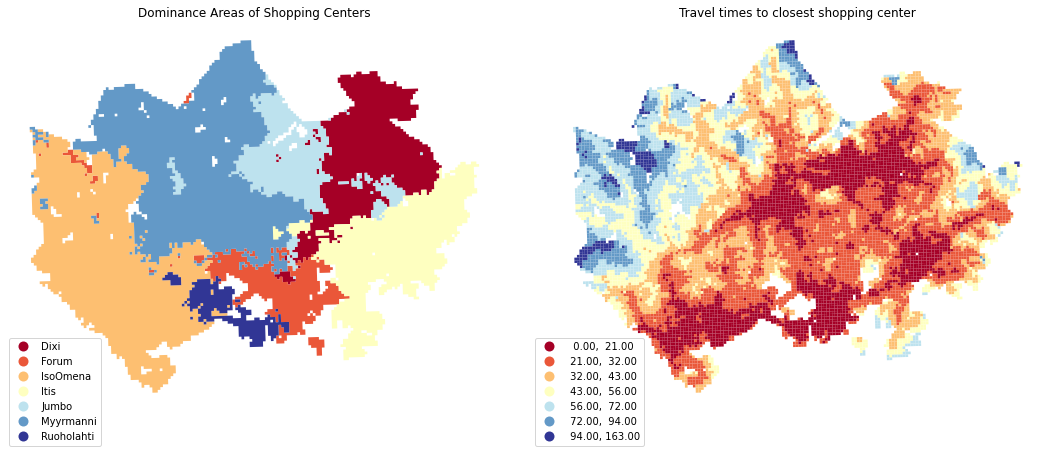

In [15]:
#how to adjust legend of a plot reference:
#https://stackoverflow.com/questions/39816790/relocating-legend-from-geopandas-plot

import matplotlib.pyplot as plt

#increase the overall figsize to allow the subplots to increase in fig_size
fig, axs = plt.subplots(nrows = 1, ncols=2, sharex=True, sharey=True, figsize= (15,15))


plot1 = dominant_service_area.plot(ax=axs[0], column='dominant_service',cmap="RdYlBu",k=7, linewidth=0, legend =True, figsize=(10, 5)) #plot a different color for each grid x 20 grids
plot1.set_title("Dominance Areas of Shopping Centers")
plot1.axis('off')
leg1 = plot1.get_legend()
leg1.set_bbox_to_anchor((0., 0., 0.2, 0.2))

plot2 = grid.plot(ax = axs[1], column= "min_t", scheme= "Natural_Breaks", k=7, cmap="RdYlBu", linewidth=0, legend = True, figsize=(10, 5))
plot2.set_title("Travel times to closest shopping center")
plot2.axis('off')

leg2 = plot2.get_legend()
leg2.set_bbox_to_anchor((0., 0., 0.2, 0.2))

plt.tight_layout()
plt.show()

The nearest shopping center to each grid is shown on the left, and the minimum travel time for each grid to each shopping center is shown on the right.

For example, to interpret this, for the Itis shopping center, the central part of the Itis shopping center has the shortest travel time. While the north west of Itis begins to have a longer travel time.

In [16]:
fig.savefig('output_ex_3.png')

That's it! If you want more challenge, you can still continue to optional problem 3. For problem 3, you need to save the grid with information about dominant services to file:

In [ ]:
# Save grid to file (if you want to continue to problem 3)

grid.to_file('All_compiled_traveled_times.shp')